# 2448540_ETE_SPR_LAB
# HMM Pronunciation Modeling and Viterbi Decoding for TALK and FOUR



---

Hidden Markov Models (HMMs) serve as a fundamental framework in speech recognition systems, where they model the relationship between acoustic observations and underlying phoneme sequences. The temporal nature of speech makes HMMs particularly well-suited for this domain, as they capture both the sequential ordering of phonemes and the variable duration of speech sounds.

The core objective here is twofold:

1. **Structural Analysis (Task 1):** Analyze the HMM structure for the word "TALK", focusing on why left-to-right constraints exist and how self-transition probabilities encode phoneme duration.

2. **Viterbi Decoding (Task 2):** Examine the mechanics of the Viterbi algorithm for the word "FOUR", including initialization, the induction step with maximization, and backtracking to recover the optimal phoneme sequence.

In practice, listening to the words "TALK" and "FOUR" through a text-to-speech tool helps build intuition about phoneme durations and sequence structure. For instance, the vowel /ɔː/ in "TALK" is noticeably longer than the plosive /t/, which directly informs how we set self-transition probabilities in our HMM.

The following sections develop these ideas through mathematical formulation, code implementation, and visualization.

---

## 1. Background: HMMs in Speech Recognition

An HMM consists of several key components:

- **States ($S$):** In speech recognition, each state typically represents a phoneme (e.g., /t/, /ɔː/, /k/).

- **Observations ($O$):** Acoustic feature vectors extracted from the speech signal (e.g., MFCCs).

- **Transition Probabilities ($a_{ij}$):** The probability of transitioning from state $i$ to state $j$. These define the allowed paths through the model.

- **Emission Probabilities ($b_i(O_t)$):** The probability of observing $O_t$ when in state $i$.

- **Initial Probabilities ($\pi_i$):** The probability of starting in state $i$.

### Left-to-Right (Bakis) HMM Structure

For speech recognition, a **left-to-right** topology is standard. In this structure:

- Transitions can only move forward (from earlier states to later states) or remain in the same state (self-loops).
- Backward transitions are forbidden ($a_{ij} = 0$ for $j < i$).

Why does this matter? Speech unfolds in time with a fixed phoneme order. Saying "TALK" means producing /t/, then /ɔː/, then /k/ in that exact sequence. A left-to-right HMM enforces this constraint by design.

### Duration Modeling via Self-Transitions

The self-transition probability $a_{ii}$ controls how long the model tends to stay in state $i$. A high $a_{ii}$ means the model is likely to remain in that state across multiple time frames, modeling a longer-duration phoneme like a vowel. Conversely, a low $a_{ii}$ causes the model to exit quickly, appropriate for short burst-like consonants.

The expected number of time steps spent in a state follows a geometric distribution. With self-transition probability $p$:

$$E[T] = \frac{1}{1 - p}$$

This formula will be used later to explain duration differences between /ɔː/ and /t/.

### Example HMM Definition

Below is a simple three-state HMM with a left-to-right structure. The transition matrix shows that backward transitions are zero, while forward and self-transitions carry probability mass.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define states for a simple 3-state left-to-right HMM
states = ['S1', 'S2', 'S3']

# Transition matrix A
# Rows: from state, Columns: to state
# Left-to-right means no backward transitions (lower triangle is zero)
transition_matrix = np.array([
    [0.3, 0.7, 0.0],   # S1 can stay or go to S2
    [0.0, 0.5, 0.5],   # S2 can stay or go to S3
    [0.0, 0.0, 1.0]    # S3 is absorbing (stays in S3)
])

# Display as DataFrame for clarity
transition_df = pd.DataFrame(transition_matrix, index=states, columns=states)
print("Transition Matrix A (Left-to-Right HMM):")
print(transition_df)

Transition Matrix A (Left-to-Right HMM):
     S1   S2   S3
S1  0.3  0.7  0.0
S2  0.0  0.5  0.5
S3  0.0  0.0  1.0


### Visualizing the Transition Matrix

A heatmap provides an intuitive view of which transitions are allowed. The zeros in the lower-left region confirm the left-to-right constraint.

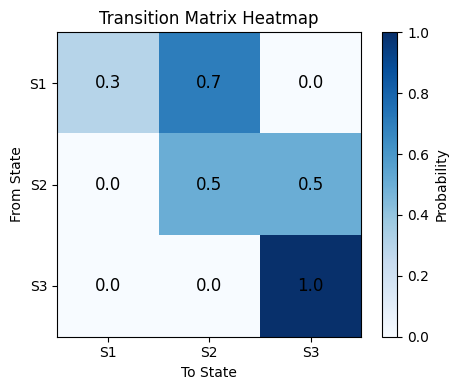

In [44]:
# Heatmap of the transition matrix
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(transition_matrix, cmap='Blues', vmin=0, vmax=1)

# Add labels
ax.set_xticks(range(len(states)))
ax.set_yticks(range(len(states)))
ax.set_xticklabels(states)
ax.set_yticklabels(states)
ax.set_xlabel('To State')
ax.set_ylabel('From State')
ax.set_title('Transition Matrix Heatmap')

# Annotate cells with probability values
for i in range(len(states)):
    for j in range(len(states)):
        ax.text(j, i, f'{transition_matrix[i, j]:.1f}', 
                ha='center', va='center', color='black', fontsize=12)

plt.colorbar(im, label='Probability')
plt.tight_layout()
plt.show()

---

## 2. Task 1: HMM Structural Analysis for the Word TALK

The word **TALK** is modeled as a three-state left-to-right HMM:

- **S1 = /t/** (voiceless alveolar plosive)
- **S2 = /ɔː/** (open-mid back rounded vowel)
- **S3 = /k/** (voiceless velar plosive)

The state sequence flows strictly as:

```
S1 (/t/)  -->  S2 (/ɔː/)  -->  S3 (/k/)
```

No arrows point backward in this diagram.

### 2.1 Task 1(a): Zero Backward Transitions and Fixed Phoneme Ordering

**Question:** Why must backward transitions like $P(/k/ \rightarrow /t/)$ or $P(/ɔː/ \rightarrow /t/)$ be zero? What linguistic property does this enforce?

---

**Answer:**

In a left-to-right HMM for a single word, backward transitions are set to zero because speech production follows a **fixed temporal order**. When pronouncing "TALK", the phonemes must appear in the sequence /t/ followed by /ɔː/ followed by /k/. There is no way to articulate /k/ and then go back to produce /t/ within a single utterance of the word.

If we allowed $P(/k/ \rightarrow /t/) > 0$, the model could generate state sequences like /t/ → /ɔː/ → /k/ → /t/, which would correspond to an impossible pronunciation. The same logic applies to $P(/ɔː/ \rightarrow /t/)$: it would allow revisiting the initial phoneme after already moving past it.

The **linguistic property** being enforced is **fixed phoneme ordering** (also known as sequential phoneme constraints). For the word "TALK", the phonemes are strictly ordered in the lexicon, and the left-to-right HMM topology encodes this by prohibiting any transition that would violate this order.

Mathematically, for states numbered 1 through N in temporal order:
$$a_{ij} = 0 \quad \text{for all } j < i$$

This constraint ensures the model can only produce valid pronunciations of the target word.

### Transition Matrix for TALK

The following code constructs the transition matrix for "TALK" with explicit state labels /t/, /ɔː/, and /k/. Backward transition probabilities are exactly zero.

In [45]:
# States for TALK
talk_states = ['/t/', '/ɔː/', '/k/']

# Transition matrix for TALK
# Using the given self-transition values: P(S1->S1)=0.1, P(S2->S2)=0.7
# S3 is terminal so it has self-transition = 1.0
talk_transition = np.array([
    [0.1, 0.9, 0.0],   # /t/: low self-loop, forward to /ɔː/
    [0.0, 0.7, 0.3],   # /ɔː/: high self-loop, forward to /k/
    [0.0, 0.0, 1.0]    # /k/: terminal state (absorbing)
])

# Verify rows sum to 1
assert np.allclose(talk_transition.sum(axis=1), 1.0), "Rows must sum to 1"

# Display as table
talk_df = pd.DataFrame(talk_transition, index=talk_states, columns=talk_states)
print("Transition Matrix for TALK:")
print(talk_df)
print("\nNote: The zeros below the diagonal confirm no backward transitions.")

Transition Matrix for TALK:
      /t/  /ɔː/  /k/
/t/   0.1   0.9  0.0
/ɔː/  0.0   0.7  0.3
/k/   0.0   0.0  1.0

Note: The zeros below the diagonal confirm no backward transitions.


### Visualization of TALK Transition Matrix

The heatmap below clearly shows the left-to-right structure. The lower-left cells are zero (no backward transitions), while the diagonal and upper triangle contain the allowed probabilities.

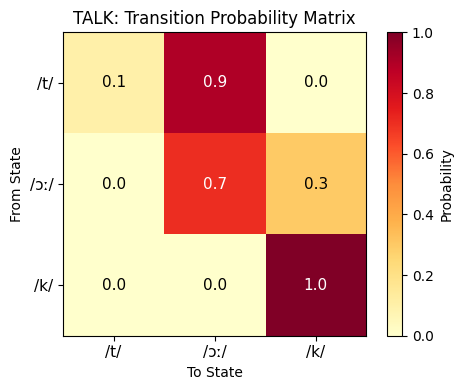

In [46]:
# Heatmap for TALK transition matrix
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(talk_transition, cmap='YlOrRd', vmin=0, vmax=1)

ax.set_xticks(range(len(talk_states)))
ax.set_yticks(range(len(talk_states)))
ax.set_xticklabels(talk_states, fontsize=11)
ax.set_yticklabels(talk_states, fontsize=11)
ax.set_xlabel('To State')
ax.set_ylabel('From State')
ax.set_title('TALK: Transition Probability Matrix')

# Annotate probabilities
for i in range(len(talk_states)):
    for j in range(len(talk_states)):
        color = 'white' if talk_transition[i, j] > 0.5 else 'black'
        ax.text(j, i, f'{talk_transition[i, j]:.1f}', 
                ha='center', va='center', color=color, fontsize=11)

plt.colorbar(im, label='Probability')
plt.tight_layout()
plt.show()

### 2.2 Task 1(b): Self-Transition Probabilities and Phoneme Duration

**Question:** The vowel /ɔː/ has $P(S2 \rightarrow S2) = 0.7$, while the plosive /t/ has $P(S1 \rightarrow S1) = 0.1$. What do these values imply about relative phoneme durations?

---

**Answer:**

The self-transition probability directly controls the expected duration of a phoneme in the HMM. A higher self-loop probability means the model is more likely to stay in that state across successive time frames, resulting in a longer modeled duration.

For the vowel **/ɔː/** (the "aw" sound in TALK):
- $P(S2 \rightarrow S2) = 0.7$
- Expected duration: $E[T] = 1/(1-0.7) = 1/0.3 \approx 3.33$ time frames

For the plosive **/t/**:
- $P(S1 \rightarrow S1) = 0.1$
- Expected duration: $E[T] = 1/(1-0.1) = 1/0.9 \approx 1.11$ time frames

This makes intuitive sense based on the acoustic properties of these sounds:

- **Vowels** like /ɔː/ are produced with an open vocal tract and can be sustained for a relatively long time. In the word "TALK", the vowel is indeed the longest segment.

- **Plosives** like /t/ are characterized by a brief burst of air following a complete closure. The /t/ in "TALK" is a very short, transient sound.

The HMM captures this acoustic reality by assigning a high self-transition probability to the vowel (so it persists across many frames) and a low self-transition probability to the plosive (so it exits quickly).

Listening to "TALK" through a TTS system confirms this: the vowel is noticeably drawn out compared to the quick initial /t/ sound.

### Computing Expected Durations

The code below calculates expected durations for /t/ and /ɔː/ using the geometric distribution formula.

In [47]:
def expected_duration(p_self):
    """Calculate expected number of time steps in a state given self-transition probability."""
    if p_self >= 1.0:
        return float('inf')  # Absorbing state
    return 1.0 / (1.0 - p_self)

# Self-transition probabilities from the problem
p_t = 0.1    # /t/ - plosive
p_vowel = 0.7  # /ɔː/ - vowel

# Compute expected durations
duration_t = expected_duration(p_t)
duration_vowel = expected_duration(p_vowel)

print(f"Self-transition probability for /t/: {p_t}")
print(f"Expected duration for /t/: {duration_t:.2f} time frames")
print()
print(f"Self-transition probability for /ɔː/: {p_vowel}")
print(f"Expected duration for /ɔː/: {duration_vowel:.2f} time frames")
print()
print(f"Ratio (vowel/plosive): {duration_vowel/duration_t:.2f}x longer")

Self-transition probability for /t/: 0.1
Expected duration for /t/: 1.11 time frames

Self-transition probability for /ɔː/: 0.7
Expected duration for /ɔː/: 3.33 time frames

Ratio (vowel/plosive): 3.00x longer


### Duration Comparison Visualization

The bar chart below makes the duration difference visually apparent. The vowel /ɔː/ is expected to last about 3 times longer than the plosive /t/.

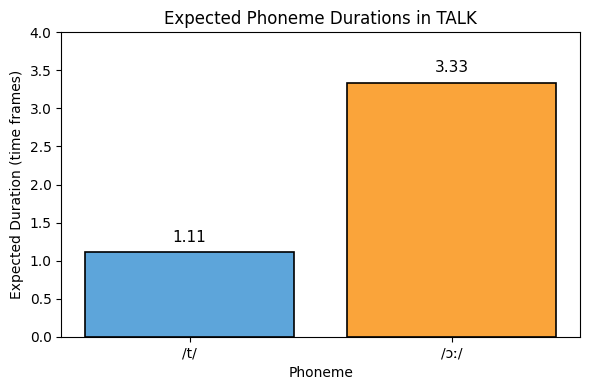

In [48]:
# Bar chart comparing expected durations
phonemes = ['/t/', '/ɔː/']
durations = [duration_t, duration_vowel]
colors = ['#5DA5DA', '#FAA43A']

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(phonemes, durations, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, dur in zip(bars, durations):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{dur:.2f}', ha='center', va='bottom', fontsize=11)

ax.set_ylabel('Expected Duration (time frames)')
ax.set_xlabel('Phoneme')
ax.set_title('Expected Phoneme Durations in TALK')
ax.set_ylim(0, 4)

plt.tight_layout()
plt.show()

---

## 3. Task 2: Viterbi Decoding Mechanics for the Word FOUR

The word **FOUR** is modeled with four states:

- **S1 = /f/** (voiceless labiodental fricative)
- **S2 = /oʊ/** (diphthong)
- **S3 = /r/** (approximant)
- **S4 = End** (terminal state)

The observation sequence is $O = [O_1, O_2, O_3, O_4]$, representing four acoustic feature frames.

### Viterbi Algorithm Overview

The Viterbi algorithm finds the **most probable state sequence** $Q^* = (q_1^*, q_2^*, \ldots, q_T^*)$ given observations $O$ and an HMM $\lambda = (A, B, \pi)$.

It proceeds in three phases:

1. **Initialization:** Compute the score for each state at $t=1$.
2. **Induction (Recursion):** For each subsequent time step, compute the best score to reach each state by taking the maximum over all possible previous states.
3. **Backtracking:** Trace back through stored pointers to recover the optimal state sequence.

The key difference from the **forward algorithm** is that Viterbi uses **maximization** instead of summation. The forward algorithm computes the total probability of all paths leading to a state (useful for likelihood computation), while Viterbi keeps only the single best path (useful for decoding).

```
Time:      t=1       t=2       t=3       t=4
           
S1 /f/      o -------> o -------> o -------> o
            |\         |\         |\
            | \        | \        | \
S2 /oʊ/     o -------> o -------> o -------> o
            |\         |\         |\
            | \        | \        | \
S3 /r/      o -------> o -------> o -------> o
            |\         |\         |\
            | \        | \        | \
S4 End      o -------> o -------> o -------> o
```

The algorithm finds the path through this lattice that maximizes the joint probability.

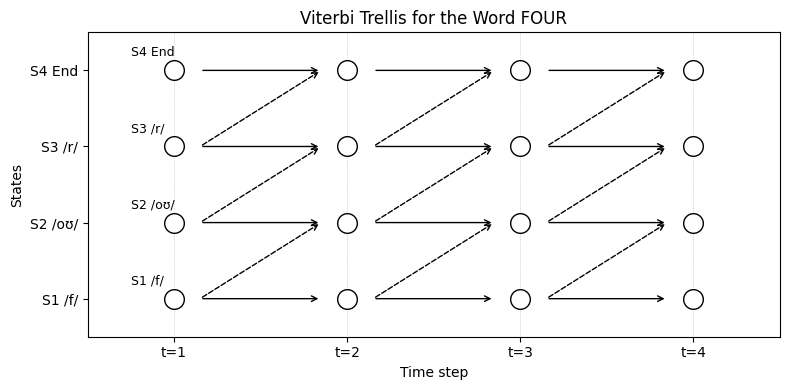

In [49]:
import matplotlib.pyplot as plt

# States and time steps
states = ["S1 /f/", "S2 /oʊ/", "S3 /r/", "S4 End"]
T = 4  # number of time steps

fig, ax = plt.subplots(figsize=(8, 4))

# Draw the nodes (circles) for each state at each time step
for s_idx, state_name in enumerate(states):
    for t in range(1, T + 1):
        # scatter point as a node
        ax.scatter(t, s_idx, s=200, edgecolor="black", facecolor="white", zorder=3)
        # add a tiny label above or below if you like
        if t == 1:
            ax.text(t - 0.25, s_idx + 0.15, state_name, fontsize=9, ha="left", va="bottom")

# Draw arrows for self-transitions (state → same state at next time)
for s_idx in range(len(states)):
    for t in range(1, T):
        ax.annotate(
            "",
            xy=(t + 1 - 0.15, s_idx),   # end point
            xytext=(t + 0.15, s_idx),   # start point
            arrowprops=dict(arrowstyle="->", lw=1),
            zorder=2,
        )

# Draw arrows for forward transitions (state → next state at next time)
for s_idx in range(len(states) - 1):  # last state usually has no forward transitions
    for t in range(1, T):
        ax.annotate(
            "",
            xy=(t + 1 - 0.15, s_idx + 1),   # end point (next state)
            xytext=(t + 0.15, s_idx),       # start point (current state)
            arrowprops=dict(arrowstyle="->", lw=1, linestyle="dashed"),
            zorder=1,
        )

# Formatting the axes
ax.set_xticks(range(1, T + 1))
ax.set_xticklabels([f"t={t}" for t in range(1, T + 1)])
ax.set_yticks(range(len(states)))
ax.set_yticklabels(states)

ax.set_xlabel("Time step")
ax.set_ylabel("States")
ax.set_title("Viterbi Trellis for the Word FOUR")

# Add a light grid to make it easier to see
ax.grid(True, axis="x", linestyle=":", linewidth=0.5)
ax.set_xlim(0.5, T + 0.5)
ax.set_ylim(-0.5, len(states) - 0.5)

plt.tight_layout()
plt.show()


### 3.1 Task 2(a): Initialization at Time t=1

**Question:** Write the general formula for $\delta_1(i)$ and explain why $\delta_1(i) = 0$ for all states except S1.

---

**Answer:**

The initialization formula for the Viterbi algorithm at $t=1$ is:

$$\delta_1(i) = \pi_i \cdot b_i(O_1)$$

Where:
- $\pi_i$ is the initial probability of starting in state $i$
- $b_i(O_1)$ is the emission probability of observing $O_1$ in state $i$

In a **strictly ordered pronunciation model** for "FOUR":
- $\pi_{S1} = 1$ (the system must start in state /f/)
- $\pi_{S2} = \pi_{S3} = \pi_{S4} = 0$ (impossible to start anywhere else)

Consequently:
- $\delta_1(S1) = 1 \cdot b_{S1}(O_1) = b_{S1}(O_1)$ (non-zero)
- $\delta_1(S2) = 0 \cdot b_{S2}(O_1) = 0$
- $\delta_1(S3) = 0 \cdot b_{S3}(O_1) = 0$
- $\delta_1(S4) = 0 \cdot b_{S4}(O_1) = 0$

The pronunciation of "FOUR" must begin with /f/. Allowing non-zero initial probability for other states would mean the word could start with /oʊ/ or /r/, which is linguistically impossible. The left-to-right structure and $\pi_{S1} = 1$ together ensure the model enforces the correct phoneme ordering from the very first time step.

### Demonstrating Initialization

The code below sets up the HMM for "FOUR" and computes $\delta_1(i)$ for all states.

In [50]:
# HMM setup for FOUR
four_states = ['/f/', '/oʊ/', '/r/', 'End']
n_states = len(four_states)

# Initial probabilities - must start in /f/
pi = np.array([1.0, 0.0, 0.0, 0.0])

# Transition matrix (left-to-right)
# Self-loops and forward transitions only
four_transition = np.array([
    [0.4, 0.6, 0.0, 0.0],   # /f/ can stay or go to /oʊ/
    [0.0, 0.5, 0.5, 0.0],   # /oʊ/ can stay or go to /r/
    [0.0, 0.0, 0.4, 0.6],   # /r/ can stay or go to End
    [0.0, 0.0, 0.0, 1.0]    # End is absorbing
])

# Dummy emission probabilities for first observation O1
# In practice these come from Gaussian mixture models or neural networks
b_O1 = np.array([0.8, 0.1, 0.05, 0.01])  # /f/ is most likely to emit O1

# Initialize delta at t=1
delta_1 = pi * b_O1

# Display results
init_df = pd.DataFrame({
    'State': four_states,
    'pi (initial prob)': pi,
    'b(O1) (emission)': b_O1,
    'delta_1 = pi * b(O1)': delta_1
})
print("Initialization at t=1:")
print(init_df.to_string(index=False))
print("\nOnly /f/ has non-zero delta_1 because pi is 1 only for S1.")

Initialization at t=1:
State  pi (initial prob)  b(O1) (emission)  delta_1 = pi * b(O1)
  /f/                1.0              0.80                   0.8
 /oʊ/                0.0              0.10                   0.0
  /r/                0.0              0.05                   0.0
  End                0.0              0.01                   0.0

Only /f/ has non-zero delta_1 because pi is 1 only for S1.


### 3.2 Task 2(b): Maximization vs Summation

**Question:** Explain the difference between maximization (Viterbi) and summation (Forward). Why is maximization needed for finding $Q^*$?

---

**Answer:**

The **Viterbi induction** formula is:

$$\delta_t(i) = \max_j \left[ \delta_{t-1}(j) \cdot a_{j,i} \right] \cdot b_i(O_t)$$

The **Forward induction** formula is:

$$\alpha_t(i) = \sum_j \left[ \alpha_{t-1}(j) \cdot a_{j,i} \right] \cdot b_i(O_t)$$

The difference lies in how paths are aggregated:

| Aspect | Viterbi (max) | Forward (sum) |
|--------|---------------|---------------|
| Operation | Maximum over previous states | Sum over previous states |
| Result | Score of best single path to state i | Total probability of all paths to state i |
| Purpose | Decoding (find best sequence) | Likelihood computation |
| Output | Single optimal sequence $Q^*$ | $P(O \mid \lambda)$ |

**Why maximization is required for finding $Q^*$:**

The goal of decoding is to find the single most probable state sequence that explains the observations. Summation would compute the total probability mass across all possible paths, which is useful for model evaluation but does not identify any specific path.

Maximization ensures that at each state and time step, only the best incoming path is retained. By tracking which previous state gave the maximum (via the $\psi$ pointer), we can later reconstruct the exact sequence that achieved the highest probability.

If we used summation instead, we would lose track of individual paths. The forward variable $\alpha_t(i)$ tells us the probability of reaching state $i$ at time $t$ via *any* path, but it cannot tell us *which* path was best.

### Comparing Max and Sum Operations

The following example demonstrates the difference between Viterbi (max) and Forward (sum) computations on a simple two-state scenario.

In [51]:
# Simple comparison: two previous states feeding into one state
# Suppose we are computing the score for state i at time t

# Previous delta/alpha values
delta_prev = np.array([0.6, 0.3])  # scores from S1 and S2 at t-1

# Transition probabilities to current state
a_to_i = np.array([0.4, 0.5])  # a(S1->i), a(S2->i)

# Emission probability for current observation
b_i = 0.7

# Path scores from each previous state
path_scores = delta_prev * a_to_i
print("Path scores from each previous state:")
print(f"  From S1: {delta_prev[0]:.2f} * {a_to_i[0]:.2f} = {path_scores[0]:.3f}")
print(f"  From S2: {delta_prev[1]:.2f} * {a_to_i[1]:.2f} = {path_scores[1]:.3f}")
print()

# Viterbi: take maximum
viterbi_score = np.max(path_scores) * b_i
best_prev = np.argmax(path_scores)
print(f"Viterbi (max): max({path_scores[0]:.3f}, {path_scores[1]:.3f}) * {b_i} = {viterbi_score:.4f}")
print(f"  Best previous state: S{best_prev+1} (stored in psi)")
print()

# Forward: take sum
forward_score = np.sum(path_scores) * b_i
print(f"Forward (sum): ({path_scores[0]:.3f} + {path_scores[1]:.3f}) * {b_i} = {forward_score:.4f}")
print(f"  No specific path tracked")
print()

print("The Viterbi score tracks the single best path, while Forward")
print("accumulates probability mass from all paths.")

Path scores from each previous state:
  From S1: 0.60 * 0.40 = 0.240
  From S2: 0.30 * 0.50 = 0.150

Viterbi (max): max(0.240, 0.150) * 0.7 = 0.1680
  Best previous state: S1 (stored in psi)

Forward (sum): (0.240 + 0.150) * 0.7 = 0.2730
  No specific path tracked

The Viterbi score tracks the single best path, while Forward
accumulates probability mass from all paths.


### Visualizing Maximization

The bar chart below shows the contribution from each previous state. The max operation selects the tallest bar (S1), discarding the others. The forward algorithm would sum all bars together.

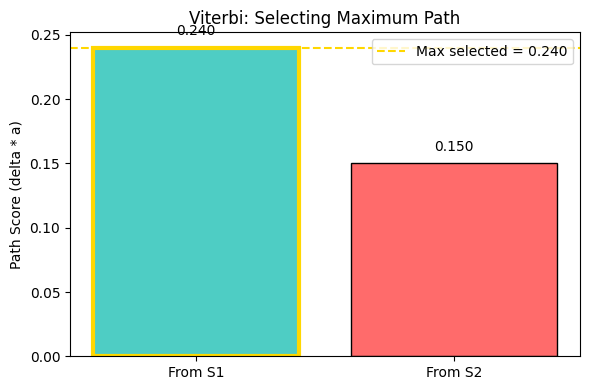

In [52]:
# Visualization of path selection
fig, ax = plt.subplots(figsize=(6, 4))

prev_states = ['From S1', 'From S2']
colors = ['#4ECDC4', '#FF6B6B']

bars = ax.bar(prev_states, path_scores, color=colors, edgecolor='black')

# Highlight the maximum
max_idx = np.argmax(path_scores)
bars[max_idx].set_edgecolor('gold')
bars[max_idx].set_linewidth(3)

ax.axhline(y=path_scores[max_idx], color='gold', linestyle='--', 
           label=f'Max selected = {path_scores[max_idx]:.3f}')

ax.set_ylabel('Path Score (delta * a)')
ax.set_title('Viterbi: Selecting Maximum Path')
ax.legend()

for bar, score in zip(bars, path_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{score:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 3.3 Task 2(c): Backtracking and the Role of psi

**Question:** Describe the role of $\psi_t(i)$ and the backtracking process.

---

**Answer:**

The variable $\psi_t(i)$ is a **pointer** that stores, for each state $i$ at time $t$, the index of the previous state $j$ that gave the maximum value during the Viterbi recursion:

$$\psi_t(i) = \arg\max_j \left[ \delta_{t-1}(j) \cdot a_{j,i} \right]$$

In essence, $\psi_t(i)$ answers the question: "If I'm in state $i$ at time $t$, which state was I in at time $t-1$ along the optimal path?"

**Backtracking Process:**

After the forward pass computes all $\delta_T(i)$ values at the final time step $T$:

1. **Select the final state:** Find the state with the highest $\delta_T$:
   $$q_T^* = \arg\max_i \delta_T(i)$$

2. **Trace back using $\psi$:** For each time step from $T-1$ down to 1:
   $$q_{t}^* = \psi_{t+1}(q_{t+1}^*)$$

3. **Reverse the sequence:** The states were collected in reverse order $(q_T^*, q_{T-1}^*, \ldots, q_1^*)$, so reverse to get the forward sequence.

**Example for FOUR:**

| Time | State at time t | psi points to |
|------|-----------------|---------------|
| T=4 | End | /r/ |
| T=3 | /r/ | /oʊ/ |
| T=2 | /oʊ/ | /f/ |
| T=1 | /f/ | (start) |

Tracing back: End $\leftarrow$ /r/ $\leftarrow$ /oʊ/ $\leftarrow$ /f/

Reversed: /f/ $\rightarrow$ /oʊ/ $\rightarrow$ /r/ $\rightarrow$ End

This gives the decoded phoneme sequence (/f/, /oʊ/, /r/, End) for the word "FOUR".

### Full Viterbi Implementation for FOUR

The following code implements the complete Viterbi algorithm, including initialization, induction, and backtracking.

In [53]:
def viterbi_decode(observations, states, pi, A, B):
    """
    Viterbi algorithm for decoding the most probable state sequence.
    
    Parameters:
    - observations: list of observation indices or values
    - states: list of state names
    - pi: initial state probabilities (n_states,)
    - A: transition matrix (n_states x n_states)
    - B: emission matrix (n_states x n_observations)
    
    Returns:
    - best_path: list of state names in the optimal sequence
    - delta: matrix of best path scores
    - psi: matrix of backpointers
    """
    T = len(observations)
    n_states = len(states)
    
    # Initialize delta and psi matrices
    delta = np.zeros((T, n_states))
    psi = np.zeros((T, n_states), dtype=int)
    
    # Initialization (t=0, using 0-indexing)
    obs_0 = observations[0]
    delta[0, :] = pi * B[:, obs_0]
    psi[0, :] = 0  # No predecessor at t=0
    
    # Induction (t=1 to T-1)
    for t in range(1, T):
        obs_t = observations[t]
        for i in range(n_states):
            # For each state i, find the best previous state j
            scores = delta[t-1, :] * A[:, i]  # element-wise: delta(t-1,j) * a(j,i)
            best_j = np.argmax(scores)
            delta[t, i] = scores[best_j] * B[i, obs_t]
            psi[t, i] = best_j
    
    # Backtracking
    best_path_indices = np.zeros(T, dtype=int)
    
    # Start with the best final state
    best_path_indices[T-1] = np.argmax(delta[T-1, :])
    
    # Trace back through psi
    for t in range(T-2, -1, -1):
        best_path_indices[t] = psi[t+1, best_path_indices[t+1]]
    
    # Convert indices to state names
    best_path = [states[i] for i in best_path_indices]
    
    return best_path, delta, psi


# Set up the HMM for FOUR
states = ['/f/', '/oʊ/', '/r/', 'End']
n_states = len(states)

# Observations (encoded as indices 0, 1, 2, 3)
observations = [0, 1, 2, 3]  # O1, O2, O3, O4
n_obs = 4

# Initial probabilities - must start in /f/
pi = np.array([1.0, 0.0, 0.0, 0.0])

# Transition matrix (left-to-right)
A = np.array([
    [0.3, 0.7, 0.0, 0.0],
    [0.0, 0.4, 0.6, 0.0],
    [0.0, 0.0, 0.3, 0.7],
    [0.0, 0.0, 0.0, 1.0]
])

# Emission matrix - rows are states, columns are observation indices
# Each row sums to 1
B = np.array([
    [0.7, 0.2, 0.05, 0.05],   # /f/ likely emits O1-type features
    [0.1, 0.6, 0.2, 0.1],     # /oʊ/ likely emits O2-type
    [0.1, 0.1, 0.6, 0.2],     # /r/ likely emits O3-type
    [0.05, 0.05, 0.1, 0.8]    # End likely emits O4-type
])

# Run Viterbi
best_path, delta, psi = viterbi_decode(observations, states, pi, A, B)

print("=" * 50)
print("Viterbi Decoding for FOUR")
print("=" * 50)

Viterbi Decoding for FOUR


In [54]:
# Display delta matrix
print("\nDelta Matrix (best path scores):")
delta_df = pd.DataFrame(delta.T, 
                        index=states, 
                        columns=[f't={t+1}' for t in range(len(observations))])
print(delta_df.round(5))


Delta Matrix (best path scores):
      t=1    t=2      t=3      t=4
/f/   0.7  0.042  0.00063  0.00001
/oʊ/  0.0  0.294  0.02352  0.00094
/r/   0.0  0.000  0.10584  0.00635
End   0.0  0.000  0.00000  0.05927


In [55]:
# Display psi matrix (backpointers)
print("\nPsi Matrix (backpointers - indices of best previous states):")
psi_df = pd.DataFrame(psi.T, 
                      index=states, 
                      columns=[f't={t+1}' for t in range(len(observations))])
print(psi_df)

# Also show psi with state names for clarity
print("\nPsi Matrix (with state names):")
psi_names = [[states[psi[t, i]] for t in range(len(observations))] for i in range(n_states)]
psi_names_df = pd.DataFrame(psi_names, 
                            index=states, 
                            columns=[f't={t+1}' for t in range(len(observations))])
print(psi_names_df)


Psi Matrix (backpointers - indices of best previous states):
      t=1  t=2  t=3  t=4
/f/     0    0    0    0
/oʊ/    0    0    1    1
/r/     0    0    1    2
End     0    0    0    2

Psi Matrix (with state names):
      t=1  t=2   t=3   t=4
/f/   /f/  /f/   /f/   /f/
/oʊ/  /f/  /f/  /oʊ/  /oʊ/
/r/   /f/  /f/  /oʊ/   /r/
End   /f/  /f/   /f/   /r/


In [56]:
# Show the decoded sequence
print("\n" + "=" * 50)
print("Decoded Phoneme Sequence:")
print(" -> ".join(best_path))
print("=" * 50)

# Show backtracking trace
print("\nBacktracking trace:")
for t in range(len(observations)-1, 0, -1):
    current = best_path[t]
    prev = best_path[t-1]
    print(f"  t={t+1}: {current} <- came from {prev} (psi[{t+1}])")


Decoded Phoneme Sequence:
/f/ -> /oʊ/ -> /r/ -> End

Backtracking trace:
  t=4: End <- came from /r/ (psi[4])
  t=3: /r/ <- came from /oʊ/ (psi[3])
  t=2: /oʊ/ <- came from /f/ (psi[2])


### Visualizing the Decoded Path

The plot below shows which state was selected at each time step. The step pattern confirms the left-to-right progression through the phoneme sequence.

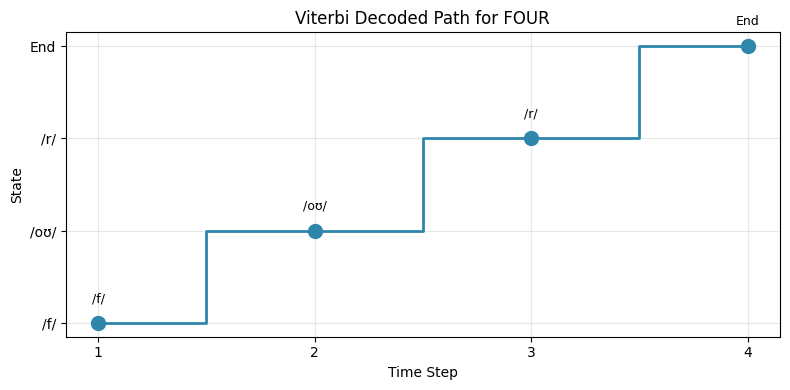

In [57]:
# Map state names to indices for plotting
state_indices = {s: i for i, s in enumerate(states)}
path_indices = [state_indices[s] for s in best_path]

# Plot the decoded path
fig, ax = plt.subplots(figsize=(8, 4))

time_steps = range(1, len(observations) + 1)
ax.step(time_steps, path_indices, where='mid', linewidth=2, 
        color='#2E86AB', marker='o', markersize=10)

ax.set_yticks(range(len(states)))
ax.set_yticklabels(states)
ax.set_xticks(time_steps)
ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('Viterbi Decoded Path for FOUR')
ax.grid(True, alpha=0.3)

# Add annotations
for t, (x, y) in enumerate(zip(time_steps, path_indices)):
    ax.annotate(states[y], (x, y), textcoords="offset points", 
                xytext=(0, 15), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Delta Matrix Heatmap

The heatmap below shows how probability mass "flows" through the states over time. Higher values (brighter colors) indicate more probable paths. The diagonal pattern reflects the left-to-right progression.

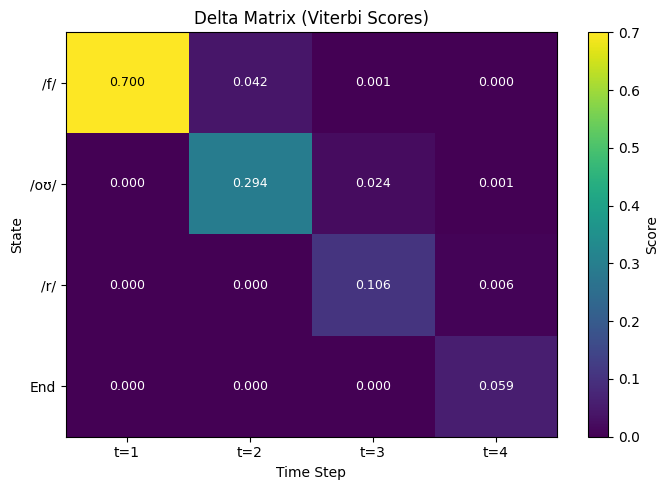

In [58]:
# Heatmap of delta values
fig, ax = plt.subplots(figsize=(7, 5))

im = ax.imshow(delta.T, cmap='viridis', aspect='auto')

ax.set_xticks(range(len(observations)))
ax.set_xticklabels([f't={t+1}' for t in range(len(observations))])
ax.set_yticks(range(len(states)))
ax.set_yticklabels(states)
ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('Delta Matrix (Viterbi Scores)')

# Annotate with values
for t in range(len(observations)):
    for i in range(len(states)):
        val = delta[t, i]
        color = 'white' if val < delta.max() / 2 else 'black'
        ax.text(t, i, f'{val:.3f}', ha='center', va='center', 
                color=color, fontsize=9)

plt.colorbar(im, label='Score')
plt.tight_layout()
plt.show()

---

## 4. Conclusion

The analysis above demonstrates several key concepts in HMM-based speech recognition:

### Left-to-Right Structure and Phoneme Ordering

The left-to-right (Bakis) HMM topology naturally models the temporal structure of speech. By setting backward transition probabilities to zero, the model enforces **fixed phoneme ordering** for words like "TALK" (/t/ -> /ɔː/ -> /k/) and "FOUR" (/f/ -> /oʊ/ -> /r/ -> End). Allowing backward transitions would permit linguistically impossible pronunciations.

### Duration Modeling via Self-Transitions

Self-transition probabilities encode expected phoneme durations. The vowel /ɔː/ with $P(S2 \rightarrow S2) = 0.7$ stays in its state for approximately 3.33 time frames on average, while the plosive /t/ with $P(S1 \rightarrow S1) = 0.1$ stays for only about 1.11 frames. This matches acoustic reality: vowels are sustained sounds, while plosives are brief bursts.

### Viterbi Algorithm Mechanics

| Phase | Description |
|-------|-------------|
| Initialization | $\delta_1(i) = \pi_i \cdot b_i(O_1)$; only the starting state has non-zero initial probability in strictly ordered models |
| Induction | $\delta_t(i) = \max_j [\delta_{t-1}(j) \cdot a_{j,i}] \cdot b_i(O_t)$; maximization identifies the single best path |
| Backtracking | $\psi_t(i)$ records the best predecessor; trace from $q_T^*$ backward to reconstruct $Q^*$ |

### Viterbi vs Forward Algorithm

| Feature | Viterbi | Forward |
|---------|---------|--------|
| Operation | Maximization | Summation |
| Output | Best state sequence $Q^*$ | Total likelihood $P(O \mid \lambda)$ |
| Use case | Decoding / recognition | Model evaluation / training |

The Viterbi algorithm is the standard approach for decoding in speech recognition because it efficiently finds the single most probable phoneme sequence, which is exactly what a pronunciation model needs to produce a transcript.